In [25]:
# Data & NLP
import re
import pandas as pd
import numpy as np
import inflect

# HuggingFace
import torch
from transformers import AutoTokenizer, AutoModel

# TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ONNX
import tf2onnx
import onnxruntime as ort

# Evaluasi
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

In [27]:
p = inflect.engine()

def convert_numbers_to_words(text):
    return " ".join([p.number_to_words(w) if w.isdigit() else w for w in str(text).split()])

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = convert_numbers_to_words(text)
    return text

# Load dataset
train_raw = pd.read_csv(r"C:\Users\User\Desktop\Skripsi\Program_Skripsi\Eksperimen1\data\dreaddit-train.csv")
test_raw  = pd.read_csv(r"C:\Users\User\Desktop\Skripsi\Program_Skripsi\Eksperimen1\data\dreaddit-test.csv")

# Cleaning
train_clean = train_raw.copy()
test_clean  = test_raw.copy()
train_clean["cleaned_text"] = train_clean["text"].map(clean_text)
test_clean["cleaned_text"]  = test_clean["text"].map(clean_text)

# Variabel khusus
X_train_text = train_clean["cleaned_text"].tolist()
X_test_text  = test_clean["cleaned_text"].tolist()
y_train = train_clean["label"].to_numpy()
y_test  = test_clean["label"].to_numpy()

train_clean[["text","cleaned_text","label"]].head()


,text,cleaned_text,label
0,"He said he had not felt that way before, sugge...",he said he had not felt that way before sugget...,1
1,"Hey there r/assistance, Not sure if this is th...",hey there r assistance not sure if this is the...,0
2,My mom then hit me with the newspaper and it s...,my mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",until i met my new boyfriend he is amazing he ...,1
4,October is Domestic Violence Awareness Month a...,october is domestic violence awareness month a...,1


In [28]:
HF_MODEL_NAME = "mental/mental-bert-base-uncased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
model = AutoModel.from_pretrained(HF_MODEL_NAME)

def get_embeddings(texts):
    embs = []
    for t in texts:
        enc = tokenizer(t, max_length=MAX_LEN, truncation=True, padding="max_length", return_tensors="pt")
        with torch.no_grad():
            out = model(**enc)
        cls = out.last_hidden_state[:,0,:].numpy()
        embs.append(cls)
    stacked = np.vstack(embs)               # (N,768)
    return np.expand_dims(stacked, axis=1)  # (N,1,768)

X_train_bert = get_embeddings(X_train_text)
X_test_bert  = get_embeddings(X_test_text)

print("MentalBERT embeddings:", X_train_bert.shape, X_test_bert.shape)


c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MentalBERT embeddings: (2838, 1, 768) (715, 1, 768)


In [29]:
def build_cnn(input_shape):
    model = Sequential([
        Conv1D(128, 1, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dropout(0.6),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model

cnn_model = build_cnn((1,768))
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 128)            98432     
                                                                 
 batch_normalization_4 (Bat  (None, 1, 128)            512       
 chNormalization)                                                
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_5 (Bat  (None, 64)               

In [30]:
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
ck = ModelCheckpoint("cnn_bert_best.h5", save_best_only=True)

start_train = time.time()
hist = cnn_model.fit(
    X_train_bert, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=8,
    callbacks=[es, rl, ck],
    verbose=1
)
end_train = time.time()

print(f"Waktu training (TF): {end_train-start_train:.2f} detik")

Epoch 1/20
284/284 [==============================] - 3s 4ms/step - loss: 1.3477 - accuracy: 0.6824 - val_loss: 0.8650 - val_accuracy: 0.8257 - lr: 0.0010
Epoch 2/20
 25/284 [=>............................] - ETA: 1s - loss: 1.1594 - accuracy: 0.6950

c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


284/284 [==============================] - 1s 4ms/step - loss: 1.0289 - accuracy: 0.7137 - val_loss: 0.7420 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 3/20
284/284 [==============================] - 1s 4ms/step - loss: 0.8768 - accuracy: 0.7410 - val_loss: 0.6505 - val_accuracy: 0.8345 - lr: 0.0010
Epoch 4/20
284/284 [==============================] - 1s 4ms/step - loss: 0.7571 - accuracy: 0.7617 - val_loss: 0.5910 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 5/20
284/284 [==============================] - 1s 4ms/step - loss: 0.6836 - accuracy: 0.7670 - val_loss: 0.5309 - val_accuracy: 0.8415 - lr: 0.0010
Epoch 6/20
284/284 [==============================] - 1s 4ms/step - loss: 0.6409 - accuracy: 0.7661 - val_loss: 0.5054 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 7/20
284/284 [==============================] - 1s 4ms/step - loss: 0.6052 - accuracy: 0.7727 - val_loss: 0.4700 - val_accuracy: 0.8415 - lr: 0.0010
Epoch 8/20
284/284 [==============================] - 1s 4ms/step - loss: 0.5578 

In [31]:
import tensorflow as tf

spec = (tf.TensorSpec((None,1,768), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(cnn_model, input_signature=spec, opset=13)
with open("cnn_bert.onnx","wb") as f:
    f.write(onnx_model.SerializeToString())

print("Model berhasil dikonversi ke cnn_bert.onnx")


Model berhasil dikonversi ke cnn_bert.onnx


23/23 [==============================] - 0s 2ms/step
== TensorFlow Model ==
              precision    recall  f1-score   support

      NotDep       0.81      0.75      0.78       346
         Dep       0.78      0.84      0.81       369

    accuracy                           0.79       715
   macro avg       0.80      0.79      0.79       715
weighted avg       0.80      0.79      0.79       715

== ONNX Model ==
              precision    recall  f1-score   support

      NotDep       0.81      0.75      0.78       346
         Dep       0.78      0.84      0.81       369

    accuracy                           0.79       715
   macro avg       0.80      0.79      0.79       715
weighted avg       0.80      0.79      0.79       715



C:\Users\User\AppData\Local\Temp\ipykernel_11396\2131920743.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_onnx.append(int(pred >= 0.5))


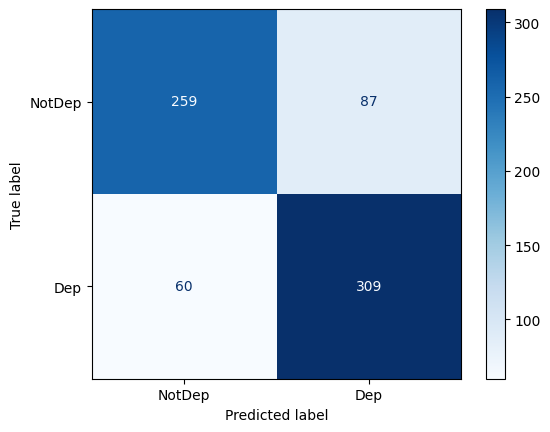

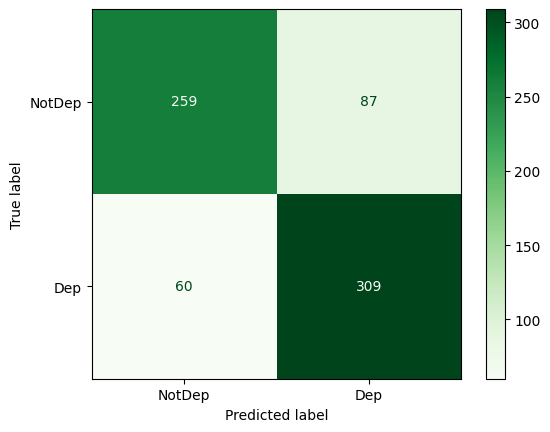

In [32]:
# Evaluasi TF
y_pred_tf = (cnn_model.predict(X_test_bert) >= 0.5).astype(int).ravel()
print("== TensorFlow Model ==")
print(classification_report(y_test, y_pred_tf, target_names=["NotDep","Dep"]))
cm_tf = confusion_matrix(y_test, y_pred_tf)
ConfusionMatrixDisplay(cm_tf, display_labels=["NotDep","Dep"]).plot(cmap="Blues")

# Evaluasi ONNX
ort_session = ort.InferenceSession("cnn_bert.onnx")
input_name = ort_session.get_inputs()[0].name

y_pred_onnx = []
for arr in X_test_bert:
    pred = ort_session.run(None, {input_name: arr.astype(np.float32)[None, :, :]})[0]
    y_pred_onnx.append(int(pred >= 0.5))
y_pred_onnx = np.array(y_pred_onnx)

print("== ONNX Model ==")
print(classification_report(y_test, y_pred_onnx, target_names=["NotDep","Dep"]))
cm_onnx = confusion_matrix(y_test, y_pred_onnx)
ConfusionMatrixDisplay(cm_onnx, display_labels=["NotDep","Dep"]).plot(cmap="Greens")


In [33]:
# TensorFlow inference
start_tf = time.time()
_ = cnn_model.predict(X_test_bert, verbose=0)
end_tf = time.time()
time_tf = end_tf - start_tf

# ONNX inference
start_onnx = time.time()
for arr in X_test_bert:
    _ = ort_session.run(None, {input_name: arr.astype(np.float32)[None, :, :]})
end_onnx = time.time()
time_onnx = end_onnx - start_onnx

print(f"Waktu inference TensorFlow : {time_tf:.4f} detik")
print(f"Waktu inference ONNX       : {time_onnx:.4f} detik")


Waktu inference TensorFlow : 0.1155 detik
Waktu inference ONNX       : 0.0319 detik


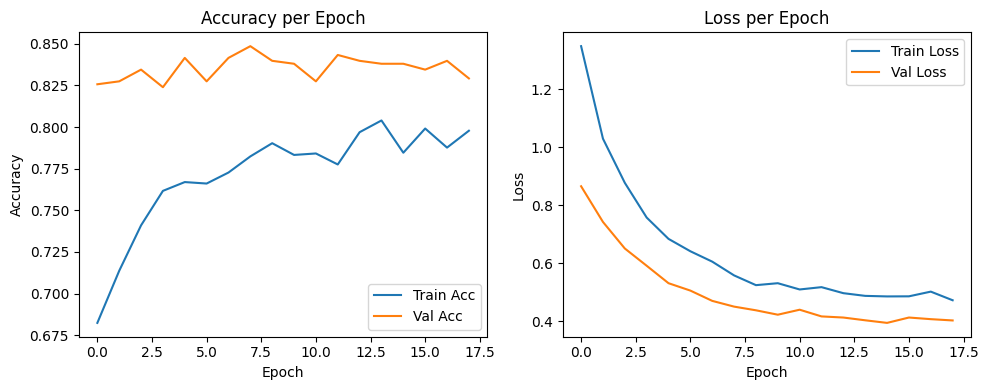

,Model,Akurasi,Waktu Inference (detik)
0,TensorFlow,0.794406,0.115475
1,ONNX,0.794406,0.031867


In [34]:
# Plot kurva training
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist.history.get("accuracy",[]), label="Train Acc")
plt.plot(hist.history.get("val_accuracy",[]), label="Val Acc")
plt.title("Accuracy per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history.get("loss",[]), label="Train Loss")
plt.plot(hist.history.get("val_loss",[]), label="Val Loss")
plt.title("Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout(); plt.show()

# Tabel ringkas perbandingan
df_compare = pd.DataFrame({
    "Model": ["TensorFlow", "ONNX"],
    "Akurasi": [
        (y_test == y_pred_tf).mean(),
        (y_test == y_pred_onnx).mean()
    ],
    "Waktu Inference (detik)": [time_tf, time_onnx]
})
df_compare


Cell Final Uji Kualitatif Eksperimen 3

In [88]:
# === 1. Import Library ===
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

pd.set_option("display.max_colwidth", None)


In [89]:
from transformers import AutoTokenizer, AutoModel

# Load MentalBERT dasar untuk ekstraksi embedding
tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
bert_extractor = AutoModel.from_pretrained("mental/mental-bert-base-uncased")


c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
# === 3. Definisi Kalimat Uji (New Test Sentences) ===
test_sentences = [
    "I feel like life has no meaning anymore.",
    "Every day I wake up exhausted and hopeless.",
    "I have no motivation to do anything.",
    "This sadness never goes away even when I try to smile.",
    "Sometimes I feel like it would be better if I just disappeared.",
    "Today I am very excited to start a new project.",
    "I enjoyed spending time with my family over the weekend.",
    "Learning new things makes me feel productive and happy.",
    "Morning exercise helps me feel refreshed.",
    "I am grateful for the small things that make life beautiful."
]


In [ ]:
# === 4. Fungsi Prediksi CNN (Original) ===
def predict_with_cnn(text, tokenizer, bert_extractor, cnn_model, max_len=128):
    encoding = tokenizer.encode_plus(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = bert_extractor(**encoding)
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
        embedding = np.expand_dims(embedding, axis=1)  # (1, 1, 768)
    prob = cnn_model.predict(embedding, verbose=0)[0][0]
    return 1 if prob >= 0.5 else 0, float(prob)

In [93]:
# === 5. Fungsi Prediksi ONNX (sudah include sigmoid, jadi tidak perlu ditambah manual) ===
def predict_with_onnx(text, tokenizer, bert_extractor, ort_session, max_len=128):
    encoding = tokenizer.encode_plus(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = bert_extractor(**encoding)
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
        embedding = np.expand_dims(embedding, axis=1).astype(np.float32)
    inputs = {ort_session.get_inputs()[0].name: embedding}
    prob = ort_session.run(None, inputs)[0][0][0]   # output sudah sigmoid
    return 1 if prob >= 0.5 else 0, float(prob)


In [94]:
# === 6. Jalankan Tes Kualitatif ===
results = []
for text in test_sentences:
    pred_cnn, prob_cnn = predict_with_cnn(text, tokenizer, bert_extractor, cnn_model)
    pred_onnx, prob_onnx = predict_with_onnx(text, tokenizer, bert_extractor, ort_session)
    results.append([text, pred_cnn, prob_cnn, pred_onnx, prob_onnx])

df_results = pd.DataFrame(results, columns=[
    "Test Sentence",
    "Pred CNN", "Prob CNN",
    "Pred ONNX", "Prob ONNX"
])

display(df_results)


,Test Sentence,Pred CNN,Prob CNN,Pred ONNX,Prob ONNX
0,I feel like life has no meaning anymore.,1,0.784914,1,0.784914
1,Every day I wake up exhausted and hopeless.,1,0.763294,1,0.763294
2,I have no motivation to do anything.,1,0.786983,1,0.786983
3,This sadness never goes away even when I try to smile.,1,0.590908,1,0.590908
4,Sometimes I feel like it would be better if I just disappeared.,0,0.389331,0,0.389331
5,Today I am very excited to start a new project.,0,0.104607,0,0.104607
6,I enjoyed spending time with my family over the weekend.,0,0.066554,0,0.066554
7,Learning new things makes me feel productive and happy.,0,0.068373,0,0.068373
8,Morning exercise helps me feel refreshed.,0,0.112563,0,0.112563
9,I am grateful for the small things that make life beautiful.,0,0.037460,0,0.037460
